## MNIST Handwritten Digits Classification Experiment

*이 노트북은 [MNIST Handwritten Digits Classification Experiment (영문 원본)](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker-experiments/mnist-handwritten-digits-classification-experiment.ipynb) 의 한국어 번역입니다.*

이 데모는 SageMaker Experiment Management Python SDK를 사용하여 ML(machine learning) 모델 학습 실험을 구성, 추적, 비교 및 평가(organize, track, compare, and evaluate)하는 방법을 보여줍니다.

여러분은 데이터셋, 알고리즘, 하이퍼파라메터(hyper-parameters) 및 평가 지표(metrics)들을 포함한 실험의 아티팩트(artifacts)를 추적할 수 있습니다. SageMaker에서 실행된 Experiments(SageMaker Autopilot jobs 및 자동으로 추적되는 training jobs)는 자동으로 추적됩니다. 모델 학습 전/후에 제공되는 ML 워크플로 내에서 추가 단계(steps)에 대한 아티팩트를 추적할 수도 있습니다 (예 : 데이터 전처리 또는 학습 후 모델 평가)

API를 사용하면 현재 및 과거 실험들을 검색 및 탐색하고 실험들을 비교하며 최고 성능 모델을 식별할 수 있습니다.

이제 MNIST 필기 숫자 분류 예제를 통해 이러한 기능을 시연해 보겠습니다. 실험은 다음과 같이 구성됩니다.

1. MNIST 데이터셋을 다운로드하여 준비합니다.
2. CNN(Convolutional Neural Network) 모델을 학습시킵니다. 모델에서 숨겨진 채널 수를 구성하는 하이퍼파라메터를 조정합니다. SageMaker Experiments Python SDK를 사용하여 파라메터 구성 및 결과 모델 정확도(acuracy)를 추적합니다.
3. Python SDK의 검색 및 분석 기능을 사용하여 2단계의 모델 튜닝에서 생성된 모든 모델 버전의 성능을 검색, 비교 및 평가합니다.
4. 또한 모델 버전의 전체 내용을 추적하는 예시, 즉 해당 모델 버전을 만드는 데 필요한 모든 데이터 전처리 및 학습 구성 및 입력 모음을 추적하는 예시도 볼 수 있습니다.

참고로, 이 노트북은 `conda_pytorch_p36` 커널이 있는 SageMaker 노트북 인스턴스에서만 실행할 수 있습니다.

### Install Python SDKs

In [1]:
import sys

In [2]:
!{sys.executable} -m pip install sagemaker-experiments

    100% |████████████████████████████████| 133kB 30.2MB/s ta 0:00:01
    100% |████████████████████████████████| 5.8MB 7.7MB/s eta 0:00:01
fastai 1.0.59 requires nvidia-ml-py3, which is not installed.
awscli 1.16.283 has requirement botocore==1.13.19, but you'll have botocore 1.13.34 which is incompatible.
  Found existing installation: botocore 1.13.19
    Uninstalling botocore-1.13.19:
      Successfully uninstalled botocore-1.13.19
  Found existing installation: boto3 1.10.19
    Uninstalling boto3-1.10.19:
      Successfully uninstalled boto3-1.10.19
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Setup

In [3]:
import time

import boto3
import numpy as np
import pandas as pd
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

import sagemaker
from sagemaker.session import Session
from sagemaker.analytics import ExperimentAnalytics

from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

In [4]:
sess = boto3.Session()
sm = sess.client('sagemaker')
role = sagemaker.get_execution_role()

### Create a S3 bucket to hold data

In [5]:
# create a s3 bucket to hold data, note that your account might already created a bucket with the same name
account_id = sess.client('sts').get_caller_identity()["Account"]
bucket = 'sagemaker-experiments-{}-{}'.format(sess.region_name, account_id)
prefix = 'mnist'

try:
    if sess.region_name == "us-east-1":
        sess.client('s3').create_bucket(Bucket=bucket)
    else:
        sess.client('s3').create_bucket(Bucket=bucket, 
                                        CreateBucketConfiguration={'LocationConstraint': sess.region_name})
except Exception as e:
    print(e)

### Dataset
MNIST 데이터셋을 다운로드한 다음 각 이미지를 변환합니다.

In [6]:
# download the dataset
# this will not only download data to ./mnist folder, but also load and transform (normalize) them
train_set = datasets.MNIST('mnist', train=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))]), 
    download=True)
                           
test_set = datasets.MNIST('mnist', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))]),
    download=False)

  0%|          | 16384/9912422 [00:00<01:18, 126548.91it/s]

9920512it [00:00, 39009613.42it/s]                           


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw


32768it [00:00, 881787.67it/s]
1654784it [00:00, 12543835.32it/s]                           

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw
Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



8192it [00:00, 406325.99it/s]


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw
Processing...
Done!


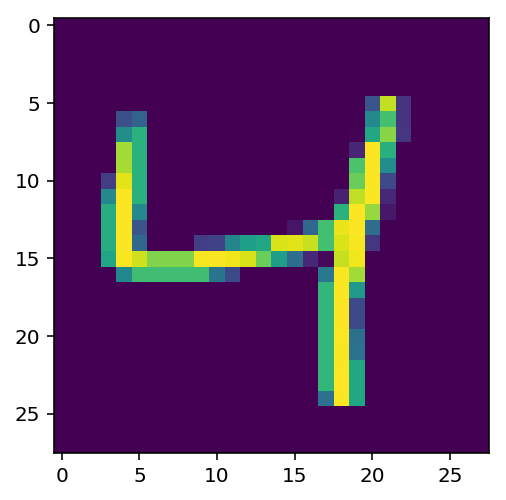

In [7]:
plt.imshow(train_set.data[2].numpy())

데이터셋 내 이미지들의 변환이 완료되었으면, s3에 업로드합니다.

In [8]:
inputs = sagemaker.Session().upload_data(path='mnist', bucket=bucket, key_prefix=prefix)
print('input spec: {}'.format(inputs))

input spec: s3://sagemaker-experiments-us-east-1-143656149352/mnist


이제 데이터 전처리 단계에서 파라메터들을 추적해 보겠습니다.

In [9]:
with Tracker.create(display_name="Preprocessing", sagemaker_boto_client=sm) as tracker:
    tracker.log_parameters({
        "normalization_mean": 0.1307,
        "normalization_std": 0.3081,
    })
    # we can log the s3 uri to the dataset we just uploaded
    tracker.log_input(name="mnist-dataset", media_type="s3/uri", value=inputs)

### Step 1 - Set up the Experiment

모든 모델 학습 반복(iterations)을 추적하는 experiment를 생성합니다. Experiment는 데이터 과학 작업을 구성하는 좋은 방법입니다. 
여러분은 Experiment를 작성하여 모든 모델 개발 작업을 구성할 수 있습니다. 몇 가지 예시들을 들어 보면 아래과 같습니다.
1. 해결하려는 비즈니스 유스 케이스 (예:"고객 이탈 예측"이라는 experiment 작성)
2. Experiment를 소유한 데이터 과학 팀 (예 :"마케팅 분석 실험"이라는 experiment)    
3. 특정 데이터 과학 및 ML 프로젝트
“파일”을 구성하기 위한 “폴더”로 생각해 보세요.

### Create an Experiment

In [10]:
mnist_experiment = Experiment.create(
    experiment_name=f"mnist-hand-written-digits-classification-{int(time.time())}", 
    description="Classification of mnist hand-written digits", 
    sagemaker_boto_client=sm)
print(mnist_experiment)

Experiment(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7f85e0fd2470>,experiment_name='mnist-hand-written-digits-classification-1575863261',description='Classification of mnist hand-written digits',experiment_arn='arn:aws:sagemaker:us-east-1:143656149352:experiment/mnist-hand-written-digits-classification-1575863261',response_metadata={'RequestId': 'adfd3070-a074-4aa2-833f-1b8c98efa55f', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'adfd3070-a074-4aa2-833f-1b8c98efa55f', 'content-type': 'application/x-amz-json-1.1', 'content-length': '123', 'date': 'Mon, 09 Dec 2019 03:47:40 GMT'}, 'RetryAttempts': 0})


### Step 2 - Track Experiment


### 이제 각 학습 실행에 대한 Trial을 만들어 입력값(inputs), 파라메터(parameters) 및 평가 지표(metrics)를 추적합니다.
SageMaker에서 CNN 모델을 학습하는 동안, 모델의 숨겨진 채널 수에 대한 몇 가지 값을 실험해 보겠습니다. 각 학습 작업 실행을 추적하기 위한 Trial을 생성해 보겠습니다. 또한 이전에 생성한 트래커(tracker)에서 TrialComponent를 만들고 Trial에 추가합니다. 이를 통해 데이터 전처리 단계에서 캡처한 파라메터로 Trial을 강화할 수 있습니다.

참고로, 다음 코드를 실행하는 데 약간의 시간이 소요됩니다.

In [11]:
from sagemaker.pytorch import PyTorch

In [12]:
hidden_channel_trial_name_map = {}

본 예제에서는 학습을 순차적으로(sequentially) 수행하고 있습니다. 만약 비동기적(asynchronously)으로 실행하려면 리소스 제한(resource limit)을 늘려야 합니다. 

In [13]:
preprocessing_trial_component = tracker.trial_component

In [ ]:
for i, num_hidden_channel in enumerate([2, 5, 10, 20, 32]):
    # create trial
    trial_name = f"cnn-training-job-{num_hidden_channel}-hidden-channels-{int(time.time())}"
    cnn_trial = Trial.create(
        trial_name=trial_name, 
        experiment_name=mnist_experiment.experiment_name,
        sagemaker_boto_client=sm,
    )
    hidden_channel_trial_name_map[num_hidden_channel] = trial_name
    
    # associate the proprocessing trial component with the current trial
    cnn_trial.add_trial_component(preprocessing_trial_component)
    
    # all input configurations, parameters, and metrics specified in estimator 
    # definition are automatically tracked
    estimator = PyTorch(
        entry_point='./mnist.py',
        role=role,
        sagemaker_session=sagemaker.Session(sagemaker_client=sm),
        framework_version='1.1.0',
        train_instance_count=1,
        train_instance_type='ml.c4.xlarge',
        hyperparameters={
            'epochs': 2,
            'backend': 'gloo',
            'hidden_channels': num_hidden_channel,
            'dropout': 0.2,
            'optimizer': 'sgd'
        },
        metric_definitions=[
            {'Name':'train:loss', 'Regex':'Train Loss: (.*?);'},
            {'Name':'test:loss', 'Regex':'Test Average loss: (.*?),'},
            {'Name':'test:accuracy', 'Regex':'Test Accuracy: (.*?)%;'}
        ],
        enable_sagemaker_metrics=True,
    )
    
    cnn_training_job_name = "cnn-training-job-{}".format(int(time.time()))
    
    # Now associate the estimator with the Experiment and Trial
    estimator.fit(
        inputs={'training': inputs}, 
        job_name=cnn_training_job_name,
        experiment_config={
            "TrialName": cnn_trial.trial_name,
            "TrialComponentDisplayName": "Training",
        },
        wait=True,
    )
    
    # give it a while before dispatching the next training job
    time.sleep(2)

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-143656149352
INFO:sagemaker:Creating training-job with name: cnn-training-job-1575863266


2019-12-09 03:47:46 Starting - Starting the training job...
2019-12-09 03:47:48 Starting - Launching requested ML instances......
2019-12-09 03:48:53 Starting - Preparing the instances for training...
2019-12-09 03:49:42 Downloading - Downloading input data...
2019-12-09 03:50:10 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2019-12-09 03:50:24,369 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2019-12-09 03:50:24,371 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-12-09 03:50:24,383 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2019-12-09 03:50:27,399 sagemaker_pytorch_container.training INFO     Invoking user training script.
2019-12-09 03:50:27,802 sagemaker-containers INFO     Module mnist does not provide a setup.py. 
Generating setup.py
2019-12-09 03:50:27,802


2019-12-09 03:51:22 Completed - Training job completed
Training seconds: 100
Billable seconds: 100


INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-143656149352
INFO:sagemaker:Creating training-job with name: cnn-training-job-1575863521


2019-12-09 03:52:02 Starting - Starting the training job...
2019-12-09 03:52:04 Starting - Launching requested ML instances......
2019-12-09 03:53:09 Starting - Preparing the instances for training...
2019-12-09 03:53:48 Downloading - Downloading input data...
2019-12-09 03:54:31 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2019-12-09 03:54:33,337 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2019-12-09 03:54:33,340 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-12-09 03:54:33,351 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2019-12-09 03:54:36,398 sagemaker_pytorch_container.training INFO     Invoking user training script.
2019-12-09 03:54:36,664 sagemaker-containers INFO     Module mnist does not provide a setup.py. 
Generating setup.p

Training seconds: 102
Billable seconds: 102


INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-143656149352
INFO:sagemaker:Creating training-job with name: cnn-training-job-1575863746


2019-12-09 03:55:46 Starting - Starting the training job...
2019-12-09 03:55:48 Starting - Launching requested ML instances......
2019-12-09 03:56:53 Starting - Preparing the instances for training...
2019-12-09 03:57:37 Downloading - Downloading input data...
2019-12-09 03:57:50 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2019-12-09 03:58:23,935 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2019-12-09 03:58:23,938 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-12-09 03:58:23,950 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2019-12-09 03:58:23,952 sagemaker_pytorch_container.training INFO     Invoking user training script.
2019-12-09 03:58:24,295 sagemaker-containers INFO     Module mnist does not provide a setup.py. 
Generating setup.py
2019-12-09 03:58:24,295


2019-12-09 03:59:31 Uploading - Uploading generated training model
2019-12-09 03:59:31 Completed - Training job completed
Training seconds: 114
Billable seconds: 114


INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-143656149352
INFO:sagemaker:Creating training-job with name: cnn-training-job-1575864002


2019-12-09 04:00:02 Starting - Starting the training job...
2019-12-09 04:00:05 Starting - Launching requested ML instances......
2019-12-09 04:01:10 Starting - Preparing the instances for training...
2019-12-09 04:02:03 Downloading - Downloading input data...
2019-12-09 04:02:30 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2019-12-09 04:02:43,558 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2019-12-09 04:02:43,561 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-12-09 04:02:43,574 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2019-12-09 04:02:46,602 sagemaker_pytorch_container.training INFO     Invoking user training script.
2019-12-09 04:02:46,966 sagemaker-containers INFO     Module mnist does not provide a setup.py. 
Generating setup.py
2019-12-09 04:02:46,966


2019-12-09 04:03:55 Uploading - Uploading generated training model
2019-12-09 04:03:55 Completed - Training job completed
Training seconds: 112
Billable seconds: 112


INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-143656149352
INFO:sagemaker:Creating training-job with name: cnn-training-job-1575864257


2019-12-09 04:04:18 Starting - Starting the training job...
2019-12-09 04:04:20 Starting - Launching requested ML instances......
2019-12-09 04:05:24 Starting - Preparing the instances for training...
2019-12-09 04:06:16 Downloading - Downloading input data...
2019-12-09 04:06:42 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2019-12-09 04:06:57,664 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2019-12-09 04:06:57,666 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-12-09 04:06:57,678 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2019-12-09 04:07:00,724 sagemaker_pytorch_container.training INFO     Invoking user training script.

2019-12-09 04:06:56 Training - Training image download completed. Training in progress.2019-12-09 04:07:16,527 sagemaker-containers INFO   


2019-12-09 04:08:35 Uploading - Uploading generated training model
2019-12-09 04:08:35 Completed - Training job completed
Training seconds: 139
Billable seconds: 139


### Compare the model training runs for an experiment

이제 Python SDK의 분석 기능을 사용하여 experiment에서 생성된 최상의 모델을 식별하기 위해 학습 실행(training runs)을 질의(query)하고 비교합니다. 검색 표현식을 사용하여 trial 구성 요소를 검색할 수 있습니다.

### Some Simple Analyses

In [ ]:
search_expression = {
    "Filters":[
        {
            "Name": "DisplayName",
            "Operator": "Equals",
            "Value": "Training",
        }
    ],
}

In [ ]:
trial_component_analytics = ExperimentAnalytics(
    sagemaker_session=Session(sess, sm), 
    experiment_name=mnist_experiment.experiment_name,
    search_expression=search_expression,
    sort_by="metrics.test:accuracy.max",
    sort_order="Descending",
    metric_names=['test:accuracy'],
    parameter_names=['hidden_channels', 'epochs', 'dropout', 'optimizer']
)

In [ ]:
analytic_table = trial_component_analytics.dataframe()

In [ ]:
analytic_table

,TrialComponentName,DisplayName,SourceArn,dropout,epochs,hidden_channels,optimizer,test:accuracy - Min,test:accuracy - Max,test:accuracy - Avg,test:accuracy - StdDev,test:accuracy - Last,test:accuracy - Count
0,cnn-training-job-1575864257-aws-training-job,Training,arn:aws:sagemaker:us-east-1:143656149352:train...,0.2,2.0,32.0,"""sgd""",95.0,97.0,96.0,1.414214,97.0,2
1,cnn-training-job-1575863266-aws-training-job,Training,arn:aws:sagemaker:us-east-1:143656149352:train...,0.2,2.0,2.0,"""sgd""",95.0,97.0,96.0,1.414214,97.0,2
2,cnn-training-job-1575863746-aws-training-job,Training,arn:aws:sagemaker:us-east-1:143656149352:train...,0.2,2.0,10.0,"""sgd""",95.0,97.0,96.0,1.414214,97.0,2
3,cnn-training-job-1575863521-aws-training-job,Training,arn:aws:sagemaker:us-east-1:143656149352:train...,0.2,2.0,5.0,"""sgd""",94.0,96.0,95.0,1.414214,96.0,2
4,cnn-training-job-1575864002-aws-training-job,Training,arn:aws:sagemaker:us-east-1:143656149352:train...,0.2,2.0,20.0,"""sgd""",96.0,96.0,96.0,0.000000,96.0,1


모델 정확도(model accuracy)에 대한 hidden 채널 변경의 영향을 격리하고 측정하기 위해, hidden 채널 수를 변경하고 다른 하이퍼파라메터의 값을 수정합니다.

다음으로 `cnn-training-job-2-hidden-channels` trial을 위해 SageMaker Experiments에서 추적한 데이터에 액세스하여 모델 계보(lineage)를 추적하는 예를 살펴 보겠습니다.

In [ ]:
lineage_table = ExperimentAnalytics(
    sagemaker_session=Session(sess, sm), 
    search_expression={
        "Filters":[{
            "Name": "Parents.TrialName",
            "Operator": "Equals",
            "Value": hidden_channel_trial_name_map[2]
        }]
    },
    sort_by="CreationTime",
    sort_order="Ascending",
)

In [ ]:
lineage_table.dataframe()

,TrialComponentName,DisplayName,normalization_mean,normalization_std,SourceArn,SageMaker.ImageUri,SageMaker.InstanceCount,SageMaker.InstanceType,SageMaker.VolumeSizeInGB,backend,...,test:accuracy - Avg,test:accuracy - StdDev,test:accuracy - Last,test:accuracy - Count,train:loss - Min,train:loss - Max,train:loss - Avg,train:loss - StdDev,train:loss - Last,train:loss - Count
0,TrialComponent-2019-12-09-021848-uwoy,Preprocessing,0.1307,0.3081,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cnn-training-job-1575863266-aws-training-job,Training,NaN,NaN,arn:aws:sagemaker:us-east-1:143656149352:train...,520713654638.dkr.ecr.us-east-1.amazonaws.com/s...,1.0,ml.c4.xlarge,30.0,"""gloo""",...,96.0,1.414214,97.0,2.0,0.157259,1.617049,0.456703,0.352488,0.157259,18.0
